In [13]:
import numpy as np
import pandas as pd
import json
import pickle
import heapq
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from nltk.tokenize import TweetTokenizer
import re
import sys
import heapq
import ipynb.fs  
sys.path.append("../")
from .defs.get_abstract_2 import count_shared_papers

In [2]:
with open('../MADStat-dataset-final-version/data.json') as json_file:
    data = json.load(json_file)
    
'''load list of authors'''
with open('../author_name.txt') as f:
    authors = f.readlines()
authors = [author.strip() for author in authors]

'''load papers info'''
papers = pd.read_csv("../paper.csv")

"""load list of authors having at least 30 papers"""
with open("../../authors","rb") as fp:
    author_l = pickle.load(fp)

/var/folders/rb/kxt2pvjx7bb3mg6mbyj8fhzc0000gn/T/ipykernel_69242/3193620936.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  papers = pd.read_csv("../paper.csv")


In [101]:
def HC(pvals, gamma=0.25, thresh=0.5):
    pvals = np.sort(pvals[pvals <= thresh])
    N = len(pvals)
    hc = -1000
    i_star = 0
    for i in range(1,int(gamma*N)+1):
        if pvals[i-1] >= 1/N:
            num = np.sqrt(N)*((i/N) - pvals[i-1])
            den = np.sqrt((i/N)*(1-i/N))
            cur = num/den
            if cur > hc:
                hc = cur
                i_star = i
    return hc, i_star

In [4]:
def clean_text(data) :
        #data.text = data.text.apply(remove_hexa_symbols)
        #data.text = data.text.apply(remove_digits)
        data = data.filter(['author', 'title', 'text']).rename(columns = {'title' : 'doc_id'})
        data["len"] = data.text.apply(lambda x: len(x))
        data.text = data.text.apply(lambda x: re.sub("All rights","",x))
        data.text = data.text.apply(lambda x: re.sub("reserved","",x))
#         data.text = data.text.apply(lambda x: re.sub("[0-9]","",x))
        data.text = data.text.apply(lambda x: re.sub("[^A-Za-z ]","",x))
        data.text = data.text.apply(lambda x: re.sub("copyright","",x))
        data.text = data.text.apply(lambda x: x.lower())
        data = data.loc[data.len > 10].reset_index()
        data.drop(columns=["len"],inplace=True)
        return data
    
def topKFrequent(nums, k):
    dic=Counter(nums)
    heapmax=[[-freq,num] for num,freq in dic.items()]
    heapq.heapify(heapmax)
    list1=[]
    for i in range(k):
        poping=heapq.heappop(heapmax)
        list1.append(poping[1])
    return list1


def get_vocab(text, max_length=200):
#     clf = CountVectorizer(lowercase=True)
#     clf.fit([text])
#     vocab = list(clf.vocabulary_.keys())
#     print("vocab before = ",vocab)
    vocab = text.split()
    k = min(max_length, len(set(vocab)))
#     return heapq.nlargest(k, vocab, key=vocab.get)
#     print(vocab)
    return topKFrequent(vocab,k)

In [5]:
"""
Input:  - text is a list of strings corresponding to documents
        - vocab is the vocabulary used for the problem
"""
def doc_to_dtm(text, vocab):
    #tk = TweetTokenizer()
    vectorizer = CountVectorizer(tokenizer=lambda txt: txt.split(),vocabulary=vocab) #tokenizer=tk.tokenize,
#     X = vectorizer.fit_transform(text)
    X = vectorizer.transform(text)
    return X.toarray()

In [6]:
def estimate_poisson(corpus):
    return np.mean(corpus,axis=0)

In [158]:
"""Return pvals using standard normal cdf"""
def get_pvals(author1,author2,show_hist=False):
    
    def replace_labels(x):
        x[x==author1] = 1
        x[x==author2] = 0
        return x

    author_1 = pd.read_csv(f'../Data/{author1}.csv').filter(['author', 'title', 'text'])
    author_2 = pd.read_csv(f'../Data/{author2}.csv').filter(['author', 'title', 'text'])
    n, m = author_1.shape[0], author_2.shape[0]
    if author1 != author2 and count_shared_papers(author1,author2,authors,data)==0 and min(n/m, m/n) >= 1/2:   
        data_ = pd.concat([clean_text(author_1),
                                          clean_text(author_2)], ignore_index=True)

        data_train = data_.sample(frac=0.7)
        data_test = data_.drop(data_train.index)
        vocab = get_vocab(''.join([doc + " " for doc in list(data_train["text"])]), max_length=400)


        text1 = data_train[data_train["author"]==author1]
        text2 = data_train[data_train["author"]==author2]

        corpus1 = doc_to_dtm(list(text1.text),vocab=vocab)
        corpus2 = doc_to_dtm(list(text2.text),vocab=vocab)
        corpus_test = doc_to_dtm(list(data_test.text),vocab=vocab)
        
        lam_1 = estimate_poisson(corpus1)
        lam_2 = estimate_poisson(corpus2)
        
        sx = np.std(corpus1,axis=0)
        sy = np.std(corpus2,axis=0)
        z = (lam_1 - lam_2)/np.sqrt((sx**2/corpus1.shape[0]) + (sy**2/corpus2.shape[0]))
        z_n = (z - np.mean(z))/np.std(z)
        if show_hist:
            plt.hist(z_n)
            plt.title(f"Normalized z-counts for {author1} and {author2}")
            plt.show()
        pvals = 1 - norm.cdf(z_n)
        hc, i_star = HC(pvals)
        
        # Prediction on test set
        c1_hc = corpus1[:,pvals <= np.sort(pvals)[i_star]]
        c2_hc = corpus2[:,pvals <= np.sort(pvals)[i_star]]
        ct_hc = corpus_test[:,pvals <= np.sort(pvals)[i_star]]
        
        Z = evaluate(ct_hc,c1_hc,c2_hc)
        y_preds = predict(Z)
        y_true = replace_labels(np.array(data_test.author))   # 1 = author1, 0 = author2
        print(f"Accuracy on test set = {accuracy(y_preds,y_true)}")
        return y_preds, y_true
    else:
        return "One author has more than twice the number of papers as the other one !!!"
        

In [152]:
def evaluate(new_data,c1,c2):
    return new_data - ((c1.sum(axis=0) + c2.sum(axis=0))/(c1.shape[0]+c2.shape[0]))

def predict(z):
    return np.where(z.sum(axis=1) > 0, 1, 0)

def accuracy(y_preds,y_true):
    return np.mean(y_preds==y_true)

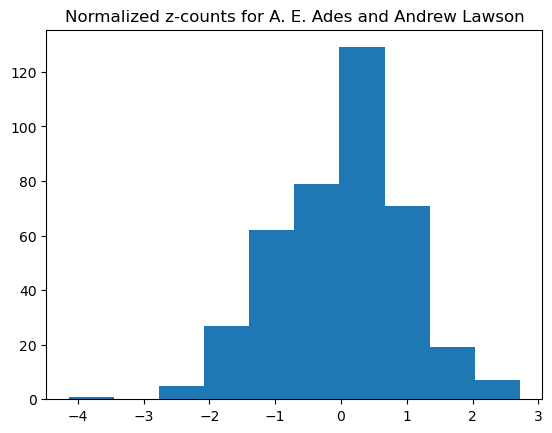

Accuracy on test set = 0.8421052631578947


(array([1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]),
 array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=object))

In [159]:
get_pvals("A. E. Ades","Andrew Lawson",show_hist=True)

In [312]:
if __name__ == "__main__":
#     author1 = "Aiyi Liu"
#     author2 = "David Cox"
    for author1 in author_l:
        for author2 in author_l:
            if author1!=author2 and count_shared_papers(author1,author2,authors,data)==0:

                author_1 = pd.read_csv(f'../Data/{author1}.csv').filter(['author', 'title', 'text'])
                author_2 = pd.read_csv(f'../Data/{author2}.csv').filter(['author', 'title', 'text'])
                if abs(author_1.shape[0] - author_2.shape[0]) <= 5:
                    data_ = pd.concat([clean_text(author_1),
                                  clean_text(author_2)], ignore_index=True)

                    data_train = data_.sample(frac=0.7)
                    data_test = data_.drop(data_train.index)
                    vocab = get_vocab(''.join([doc for doc in list(data_train["text"])]))

                    text1 = data_train[data_train["author"]==author1]
                    text2 = data_train[data_train["author"]==author2]
                    
                    text1
                    #corpus1 = doc_to_dtm(["".join(list(text1.text))],vocab=vocab)
                    corpus1 = doc_to_dtm(list(text1.text),vocab=vocab)
                    corpus2 = doc_to_dtm(list(text2.text),vocab=vocab)

                    lam_1 = estimate_poisson(corpus1)
                    lam_2 = estimate_poisson(corpus2)
                    y_pred = []
                    for doc in list(data_test["text"]):
                        dtm = doc_to_dtm([doc],vocab=vocab)
                        if np.sum((dtm - lam_1)**2) < np.sum((dtm - lam_2)**2):
                            y_pred.append(author1)
                        else:
                            y_pred.append(author2)


                    """Accuracy and F1 score on test set"""
                    y_true = list(data_test["author"])
                    y_pred = [0 if item==author1 else 1 for item in y_pred]
                    y_true = [0 if item==author1 else 1 for item in y_true]
                    acc = np.mean(np.array(y_pred)==np.array(y_true))
                    f1 = f1_score(y_pred, y_true)
                    if acc <= 0.6 or f1 <= 0.5:
                        print(f"TESTING {author1} AGAINST {author2}")
                        print("Accuracy on test set = ",np.mean(np.array(y_pred)==np.array(y_true)))
                        print("f1 score = ",f1_score(y_pred, y_true))
                        print("-----------------------------------------------------------------")
                #corpus2 = doc_to_dtm(["".join(list(text2.text))],vocab=vocab)
    #             print(f"corpus of {author1}: \n")
    #             print(corpus1)
    #             print("---------------------------------------------------")
    #             print(f"corpus of {author2}: \n")
    #             print(corpus2)
                #print("vocabulary = ", vocab)
                #print(get_vocab("hello hello hello my my my name is name gabr gabr it it it it it it it it"))

TESTING A. E. Ades AGAINST Andrew Lawson
Accuracy on test set =  0.5789473684210527
f1 score =  0.6
-----------------------------------------------------------------
TESTING A. E. Ades AGAINST Byron Jones
Accuracy on test set =  0.6
f1 score =  0.6363636363636364
-----------------------------------------------------------------
TESTING A. E. Ades AGAINST Chuanhai Liu
Accuracy on test set =  0.5263157894736842
f1 score =  0.5263157894736842
-----------------------------------------------------------------
TESTING A. E. Ades AGAINST Dennis Boos
Accuracy on test set =  0.55
f1 score =  0.5263157894736842
-----------------------------------------------------------------
TESTING A. E. Ades AGAINST Dianne M. Finkelstein
Accuracy on test set =  0.5789473684210527
f1 score =  0.6
-----------------------------------------------------------------
TESTING A. E. Ades AGAINST John Lachin
Accuracy on test set =  0.7368421052631579
f1 score =  0.4444444444444445
--------------------------------------

KeyboardInterrupt: 

In [25]:
pvals = 1 - norm.cdf(z_n)
HC = HC(list(pvals))
np.array(vocab)[pvals <= HC]

array(['the', 'of', 'a', 'to', 'and', 'is', 'in', 'for', 'we', 'are',
       'with', 'data', 'model', 'that', 'as', 'models', 'this', 'on',
       'be', 'an', 'spatial', 'by', 'process', 'from', 'using',
       'approach', 'which', 'at', 'bayesian', 'can', 'such',
       'distribution', 'two', 'or', 'random', 'mixture', 'each', 'our',
       'effects', 'it', 'modeling', 'analysis', 'these', 'given',
       'regression', 'used', 'algorithm', 'set', 'hierarchical', 'one',
       'posterior', 'distributions', 'inference', 'sample', 'fitting',
       'not', 'problem', 'species', 'have', 'where', 'level', 'also',
       'when', 'information', 'methods', 'more', 'proposed', 'error',
       'results', 'based', 'observed', 'performance', 'been', 'function',
       'interest', 'number', 'over', 'well', 'class', 'functions',
       'population', 'provide', 'sampling', 'through', 'both', 'case',
       'conditional', 'estimation', 'has', 'illustrate', 'paper',
       'probability', 'test', 'varia